### Import libraries

In [269]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from pandas import DataFrame
from keras import Sequential
from statsmodels.tsa.seasonal import seasonal_decompose

### Utility functions 

In [270]:

def split_train_validate_test(df: DataFrame, train_percent=.6, validate_percent=.2, test_percent=.2):
    df.sort_values(by="Date", inplace=True) 
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    
    train = df.iloc[:train_end]
    validate = df.iloc[train_end:validate_end]
    test = df.iloc[validate_end:]
    
    return train, validate, test

def plot_history(history):
    history_dict = history.history

    #MAE
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 1)
    plt.plot(history_dict['mae'], label='Training MAE')
    plt.plot(history_dict['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')

    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid(True)

    #MSE
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2)
    plt.plot(history_dict['mse'], label='Training MSE')
    plt.plot(history_dict['val_mse'], label='Training MSE')

    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Training and Validation MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def load_data():
    df = pd.read_csv('./training_data/GBPUSD_open_5year.csv')
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
    df.sort_values(by="Date", inplace=True)
    return df


def plot_gbp_usd(data):
    plt.figure(figsize=(14, 7))
    plt.title('GBPUSD Exchange Rate')
    plt.ylabel('Price GBP-USD')

    colors = plt.cm.tab10.colors  # Use a colormap for distinct colors

    # Iterate through each dataset in the array
    for idx, dataset in enumerate(data):
        dates = dataset[0]
        prices = dataset[1]
        plt.plot(dates, prices, label=f'Line {idx + 1}', color=colors[idx % len(colors)], alpha=0.7)

    plt.xticks(pd.date_range(start=min(dates), end=max(dates), freq='3MS'), rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

def pre_process_data(df: DataFrame):
	decomp = seasonal_decompose(df["Open"], model='additive', period=30)  # Change period based on seasonality
	df["Trend"] = decomp.trend.bfill().ffill()
	df["Seasonality"] = decomp.seasonal.bfill().ffill()
	df["Noise"] = decomp.resid.bfill().ffill()

	df["Week"] = df["Date"].dt.isocalendar().week
	df["Month"] = df["Date"].dt.month
	df["Day"] = df["Date"].dt.day
	return df

def plot_pre_processed_data(df: DataFrame):
	# Plot the decomposed components
	plt.figure(figsize=(14, 10))

	# Plot the original data
	plt.subplot(4, 1, 1)
	plt.plot(df["Date"], df["Open"], label="Original")
	plt.title("Original Data")
	plt.legend()

	# Plot the trend
	plt.subplot(4, 1, 2)
	plt.plot(df["Date"], df["Trend"], label="Trend", color="orange")
	plt.title("Trend")
	plt.legend()

	# Plot the seasonality
	plt.subplot(4, 1, 3)
	plt.plot(df["Date"], df["Seasonality"], label="Seasonality", color="green")
	plt.title("Seasonality")
	plt.legend()

	# Plot the noise
	plt.subplot(4, 1, 4)
	plt.plot(df["Date"], df["Noise"], label="Noise", color="red")
	plt.title("Noise")
	plt.legend()

	plt.tight_layout()
	plt.show()

def plot_train_val_evaluation_history(t, v, type="MAE"):
    plt.figure(figsize=(12, 6))
    plt.plot(t, label=f'Training {type}', color='blue')
    plt.plot(v, label=f'Validation {type}', color='orange')
    plt.title("Training and validation " + type)
    plt.xlabel('Epochs')
    plt.ylabel(f'Mean {"Absolute" if type == "MAE" else "Squared"} Error ({type})')
    plt.legend()
    plt.grid(True)
    plt.show()

def print_evaluation_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true.values - y_pred.flatten()) / y_true.values)) * 100
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"R^2 Score: {r2:.3f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")
    return {"MAE": mae, "MSE": mse, "R Square": r2, "MAPE": mape}

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

def time_sequence_generator(feature, target, time_step):
    X = []
    y = []
    # Iterate over data to create sequences
    for i in range(time_step, len(feature)):
        X.append(feature[i - time_step:i])  
        y.append(target[i])  
    
    return np.array(X), np.array(y)

# 1. Visualize the data

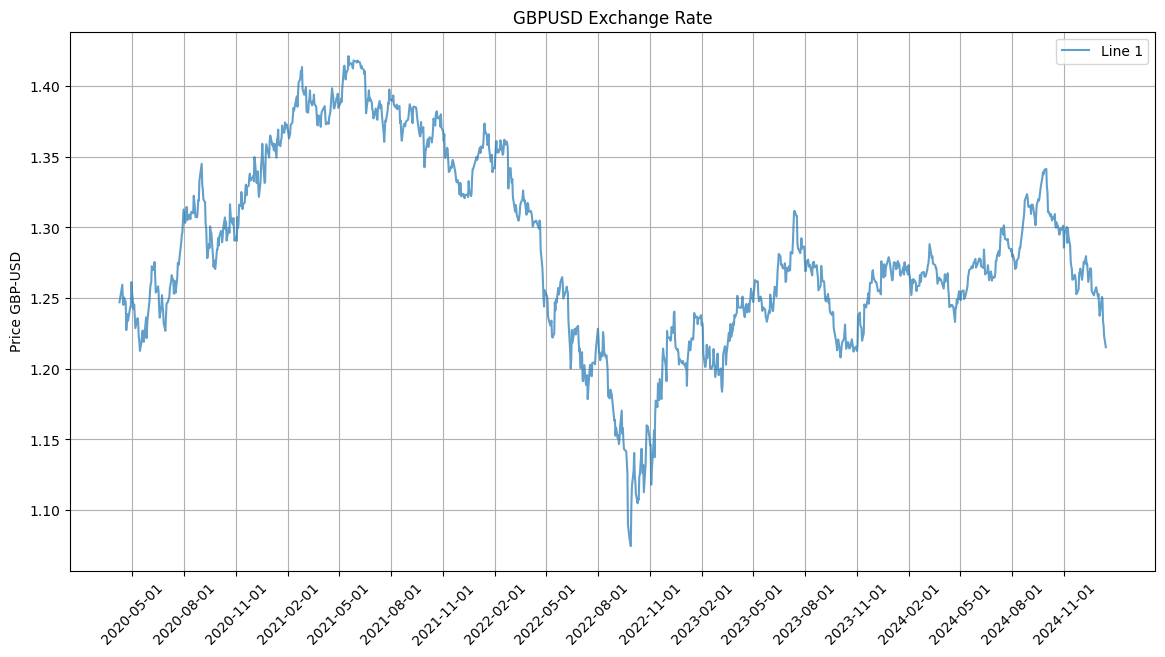

In [271]:
data = load_data()
plot_gbp_usd([[data['Date'], data['Open']]])

# 2. Pre-process the data

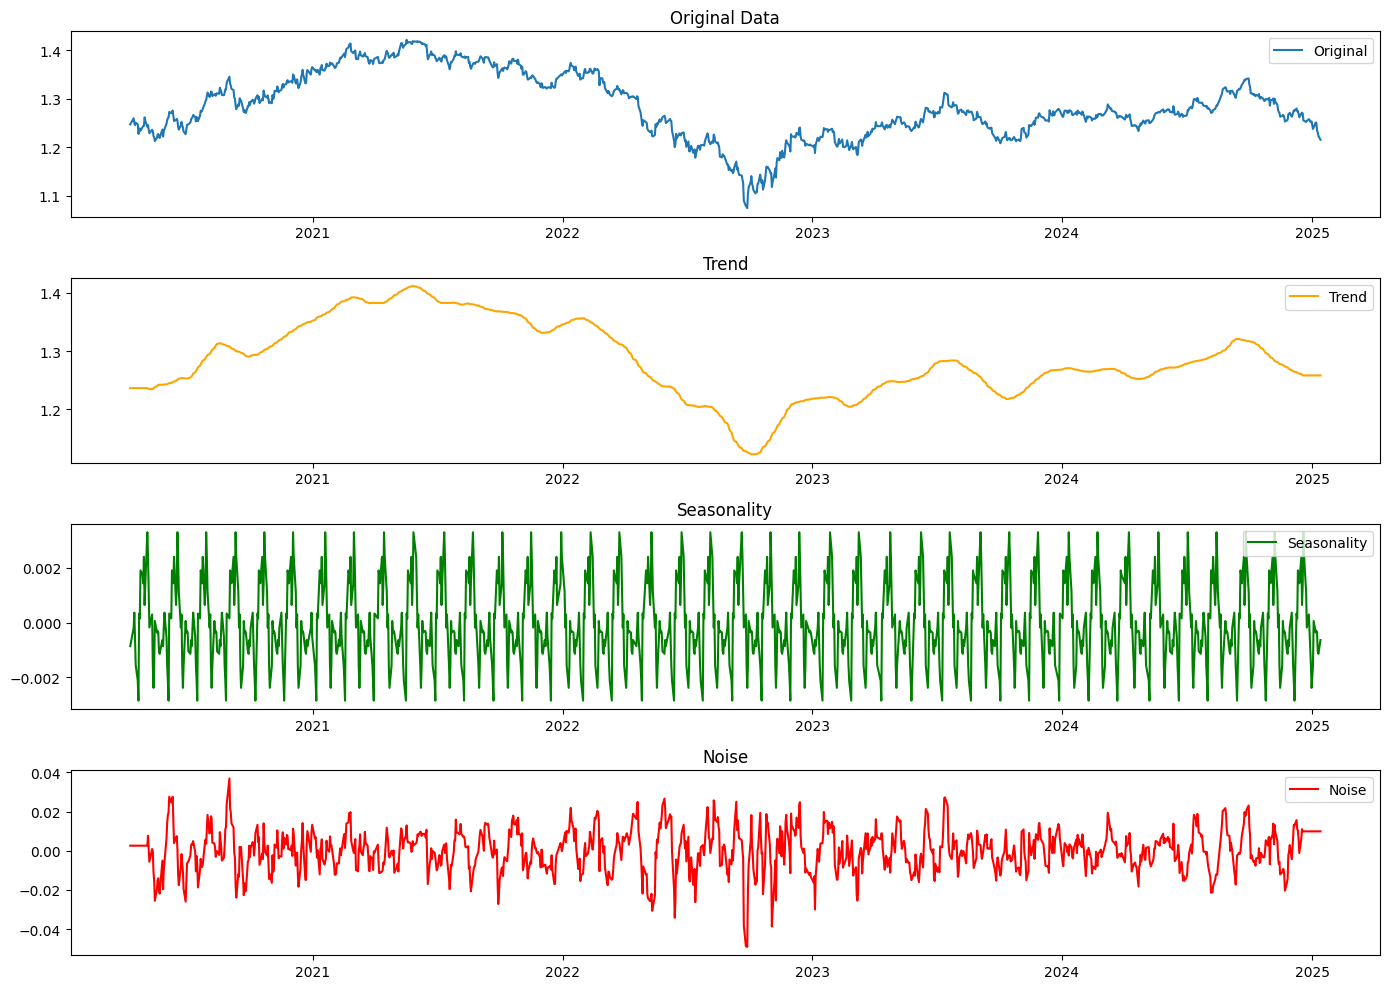

In [272]:
# General pre-process data for overall models
df = load_data()
df = pre_process_data(df)
plot_pre_processed_data(df)


# 3. Model based on each time instance

### 3.1 Split the Test, validate and Train data 

In [273]:
# Training  and Target Features
features = ['Trend', 'Seasonality', 'Noise', 'Week', 'Month', 'Day']
target = "Open"

# Split data 
u_train, u_validate, u_test = split_train_validate_test(df, train_percent=.7, validate_percent=0.15, test_percent=.15)

### 3.2 Scale the features and target

In [274]:
# Normalize data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale train, validate, and test sets
# Feature and target scaling on Training data 
train = pd.DataFrame()
feature_scaler.fit_transform(u_train[features])
target_scaler.fit_transform(u_train[[target]])

train['Date'] = u_train['Date']
train[features] = feature_scaler.transform(u_train[features])
train[target] = target_scaler.transform(u_train[[target]])

validate = pd.DataFrame()
validate['Date'] = u_validate['Date']
validate[features] = feature_scaler.transform(u_validate[features])
validate[target] = target_scaler.transform(u_validate[[target]])

test = pd.DataFrame()
test['Date'] = u_test['Date']
test[features] = feature_scaler.transform(u_test[features])
test[target] = target_scaler.transform(u_test[[target]])


### 3.3 Develop a base model

In [275]:
# Define the model
base_dnn_model = Sequential([
	layers.Dense(128, activation='relu', input_shape=(len(features),)),
	layers.Dense(128, activation='relu'),
	layers.Dense(1)  # Output layer for regression
])

# Compile the model
base_dnn_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

base_dnn_history = base_dnn_model.fit(train[features], train[target], epochs=40, batch_size=1, validation_data=(validate[features], validate[target]))


Epoch 1/40


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


840/840 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - loss: 0.0102 - mae: 0.0533 - mse: 0.0102 - val_loss: 1.7393e-04 - val_mae: 0.0094 - val_mse: 1.7393e-04
Epoch 2/40
840/840 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/step - loss: 3.3384e-04 - mae: 0.0139 - mse: 3.3384e-04 - val_loss: 1.3252e-04 - val_mae: 0.0084 - val_mse: 1.3252e-04
Epoch 3/40
840/840 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step - loss: 1.9678e-04 - mae: 0.0107 - mse: 1.9678e-04 - val_loss: 5.5559e-04 - val_mae: 0.0218 - val_mse: 5.5559e-04
Epoch 4/40
840/840 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step - loss: 3.3442e-04 - mae: 0.0144 - mse: 3.3442e-04 - val_loss: 8.9248e-05 - val_mae: 0.0079 - val_mse: 8.9248e-05
Epoch 5/40
840/840 ━━━━━━━━━━━━━━━━━━━━ 1s 596us/step - loss: 3.9233e-04 - mae: 0.0144 - mse: 3.9233e-04 - val_loss: 2.6112e-05 - val_mae: 0.0036 - val_mse: 2.6112e-05
Epoch 6/40
840/840 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step - loss: 1.4049e-04 - mae: 0.0087 - mse: 1.4049e-04 - val_loss: 1.8071e-04 - val_mae: 0.0119 - val_mse: 1.8071e-04
Epoch 7/40


### 3.4 Base model evaluation 

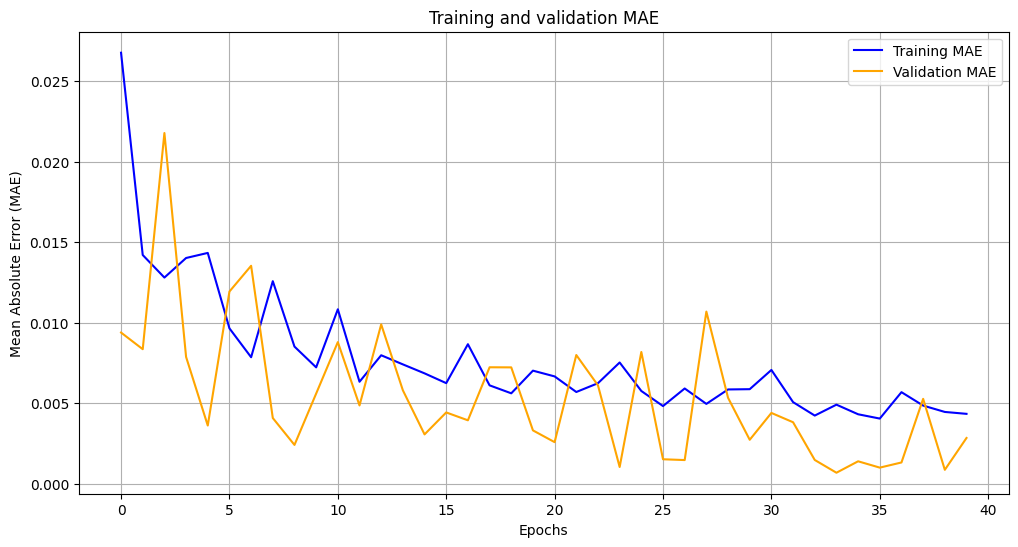

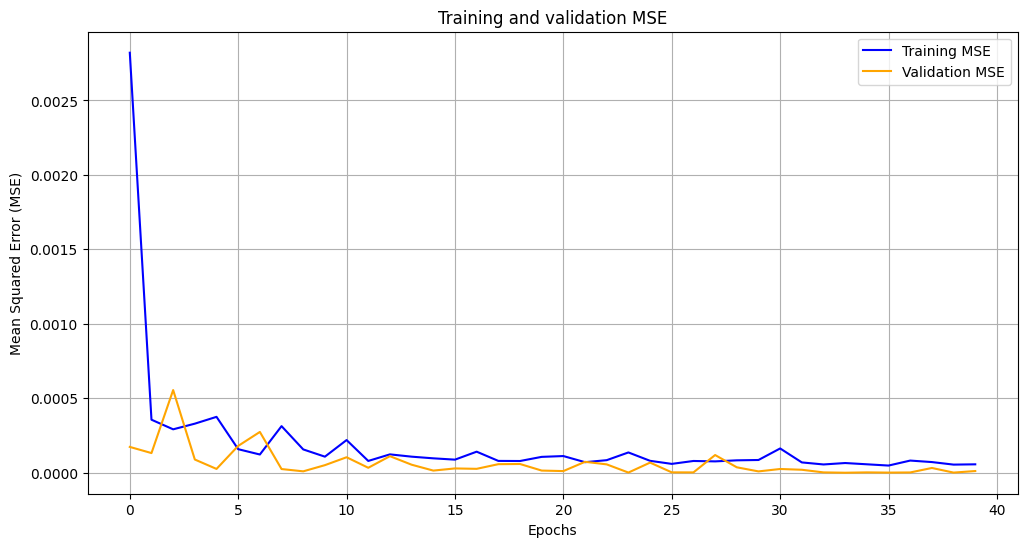

In [276]:
history = base_dnn_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")


### 3.5 Hyper-tuning

In [277]:
#build model
def build_model(hp):
    model = Sequential()
    num_layers_params = hp.Int('num_layers', 2, 4, step=5)

    i = 0
    unit_params = hp.Int(f'units_{i}', min_value=64, max_value=128, step=32)
    model.add(layers.Dense(units=unit_params, activation="relu", input_dim=len(features)))
    for i in range(1, num_layers_params):  
        model.add(layers.Dense(units=unit_params, activation='relu'))

    model.add(layers.Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

    return model

tuner = kt.Hyperband(build_model, objective='val_mse', factor=3, directory='nn_cache', project_name='DNN_tuning')
tuner.search(train[features],train[target],  epochs=50, validation_data=(validate[features], validate[target]), verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps_dict = best_hps.values
best_hps_df = pd.DataFrame(list(best_hps_dict.items()), columns=['Hyperparameter', 'Value'])
best_hps_df

Reloading Tuner from nn_cache/DNN_tuning/tuner0.json


,Hyperparameter,Value
0,num_layers,2
1,units_0,96
2,tuner/epochs,2
3,tuner/initial_epoch,0
4,tuner/bracket,4
5,tuner/round,0


### 3.6 Evaluate hyper-tuned model 

Epoch 1/10


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1284 - mae: 0.2847 - mse: 0.1284 - val_loss: 0.0030 - val_mae: 0.0454 - val_mse: 0.0030
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100 - mae: 0.0771 - mse: 0.0100 - val_loss: 0.0015 - val_mae: 0.0340 - val_mse: 0.0015
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - mae: 0.0265 - mse: 0.0011 - val_loss: 3.4264e-04 - val_mae: 0.0142 - val_mse: 3.4264e-04
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5265e-04 - mae: 0.0156 - mse: 4.5265e-04 - val_loss: 1.8176e-04 - val_mae: 0.0107 - val_mse: 1.8176e-04
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7586e-04 - mae: 0.0125 - mse: 2.7586e-04 - val_loss: 2.2866e-04 - val_mae: 0.0124 - val_mse: 2.2866e-04
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6300e-04 - mae: 0.0096 - mse: 1.6300e-04 - val_loss: 1.4081e-04 - val_mae: 0.0096 - val_mse: 1.4081e-04
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3175e-0

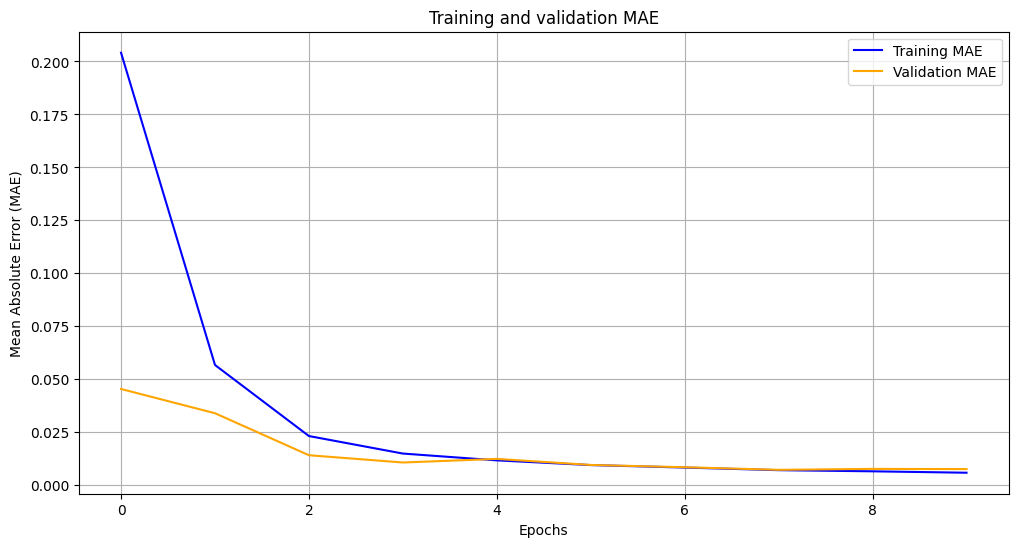

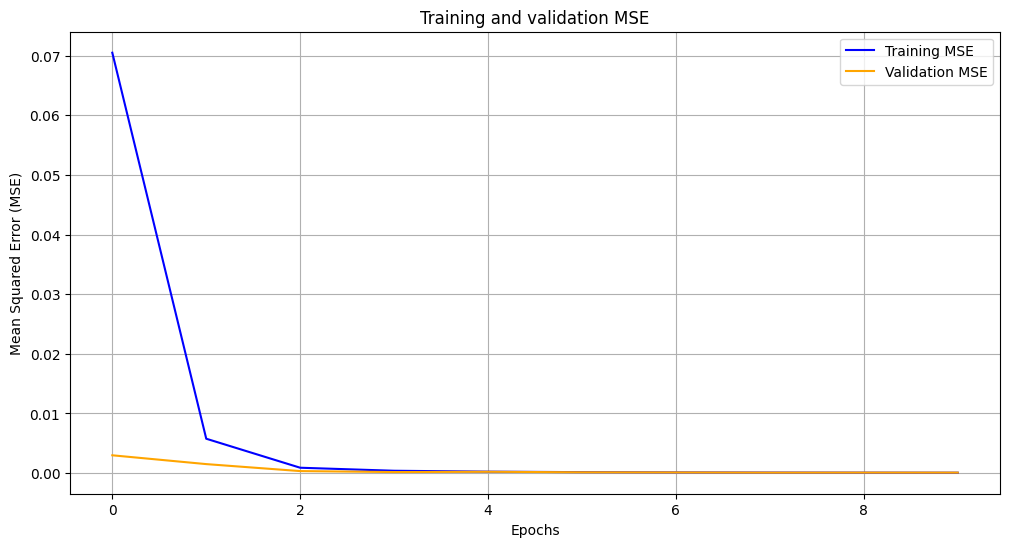

Mean Absolute Error (MAE): 0.009
Mean Squared Error (MSE): 0.001
R^2 Score: 0.886
Mean Absolute Percentage Error (MAPE): 1.774%


In [278]:

# Train the model with the best hyperparameters
dnn_model = build_model(best_hps)
history = dnn_model.fit(train[features], train[target], epochs=10, validation_data=(validate[features], validate[target]))

# Extract training and validation metrics
train_mae = history.history['mae']
train_mse = history.history['mse']
val_mae = history.history['val_mae']
val_mse = history.history['val_mse']

# Get model predictions on Test Data
y_pred = base_dnn_model.predict(test[features])
y_true = test[target]

# Plot the training and validation MAE and MSE 
plot_train_val_evaluation_history(train_mae, val_mae, "MAE")
plot_train_val_evaluation_history(train_mse, val_mse, "MSE")

# Print Evaluation Metrics
dnn_metric =  print_evaluation_metrics(y_true, y_pred)

### 3.7 Overview of whole predicted model 

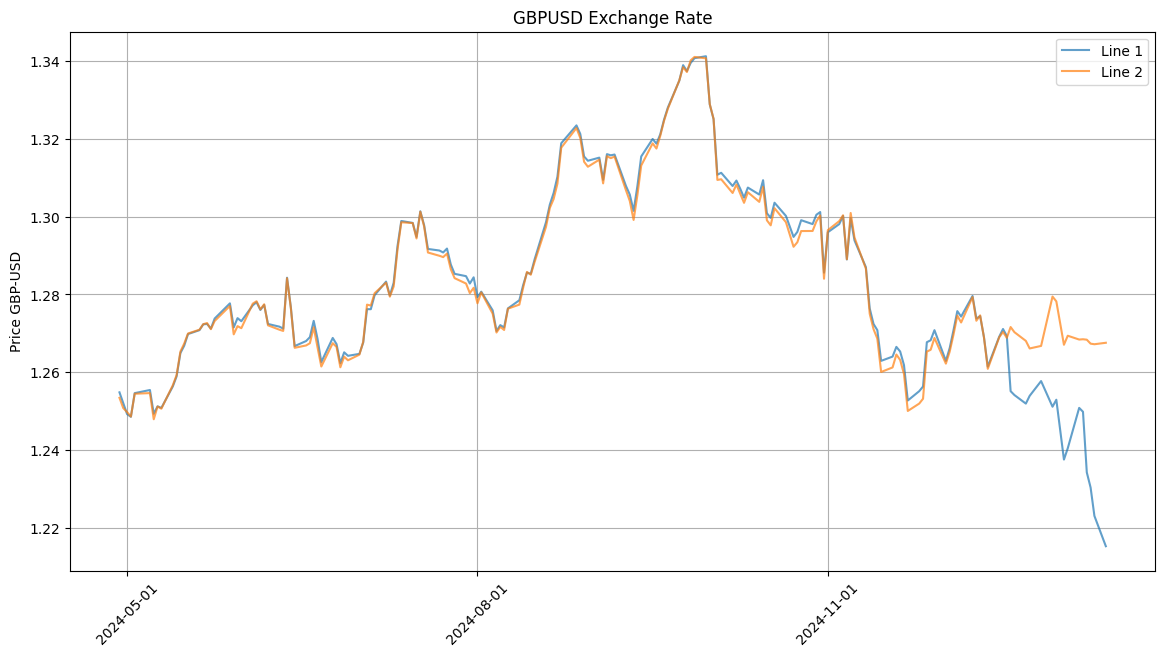

In [279]:
y_pred_unscaled = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test_unscaled = u_test[target].values

actual_data = [test["Date"], y_test_unscaled]
predicted_data = [test["Date"], y_pred_unscaled]

dnn_predicted = y_pred_unscaled

plot_gbp_usd([actual_data, predicted_data])

# 4 LSTM Neural Network (Time Series)

### 4.1 Implementing scaler on dataset

In [280]:
# Update the features as working with sequence data, its better to use previous open price as a feature
# Scaling the feature with updated scaler
features = ['Trend', 'Seasonality', 'Noise', 'Week', 'Month', 'Day', 'Open']
feature_scaler = MinMaxScaler()
feature_scaler.fit(u_train[features])

# Creating a scaled dataframe
scaled_df = pd.DataFrame()

# Implementing Scaler on whole data  
scaled_df['Date'] = df['Date']
scaled_df[features] = feature_scaler.transform(df[features])
scaled_df[target] = target_scaler.transform(df[[target]])

### 4.2 Splitting & Generate Sequence

In [281]:
SEQ_LENGTH = 7

# Splitting the scaled data into train, validate, and test sets
train, validate, test = split_train_validate_test(scaled_df, train_percent=.7, validate_percent=0.15, test_percent=.15)

train_feature_seq, train_target_seq = time_sequence_generator(
    train[features].values, 
    train[target].values, 
    SEQ_LENGTH
)

validation_feature_seq, validation_target_seq = time_sequence_generator(
    validate[features].values, 
    validate[target].values, 
    SEQ_LENGTH)

test_feature_seq, test_target_seq = time_sequence_generator(
    test[features].values, 
    test[target].values, 
    SEQ_LENGTH
)

print(test_feature_seq.shape, test_target_seq.shape)

(173, 7, 7) (173,)


### 4.3 Train base model

In [282]:
lstm_base_model = Sequential([
    layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])),
    layers.LSTM(50, activation='relu'),
    layers.Dense(1)
])

lstm_base_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

base_lstm_history = lstm_base_model.fit(test_feature_seq, test_target_seq, epochs=50, batch_size=32, validation_data=(validation_feature_seq, validation_target_seq))

Epoch 1/50


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.3749 - mae: 0.6072 - mse: 0.3749 - val_loss: 0.1928 - val_mae: 0.4337 - val_mse: 0.1928
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2376 - mae: 0.4816 - mse: 0.2376 - val_loss: 0.0970 - val_mae: 0.3004 - val_mse: 0.0970
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1121 - mae: 0.3225 - mse: 0.1121 - val_loss: 0.0183 - val_mae: 0.1120 - val_mse: 0.0183
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0167 - mae: 0.1037 - mse: 0.0167 - val_loss: 0.0515 - val_mae: 0.1814 - val_mse: 0.0515
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0298 - mae: 0.1287 - mse: 0.0298 - val_loss: 0.0139 - val_mae: 0.1084 - val_mse: 0.0139
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0090 - mae: 0.0824 - mse: 0.0090 - val_loss: 0.0116 - val_mae: 0.0920 - val_mse: 0.0116
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0123 - mae: 0.0996 - mse: 0.0123 - val_loss: 0.0096 - val_mae: 0.0885 

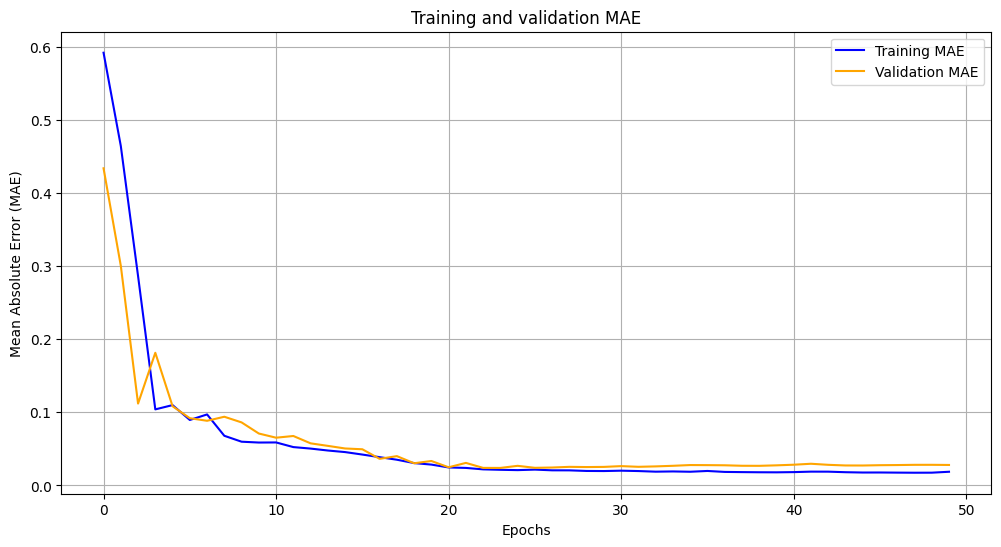

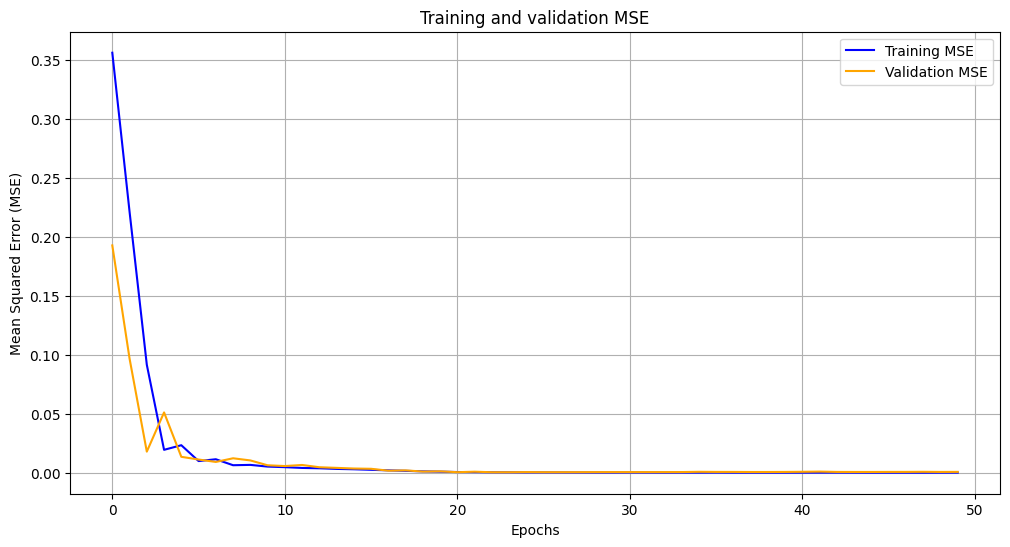

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Mean Absolute Error (MAE): 0.017
Mean Squared Error (MSE): 0.000
R^2 Score: 0.909
Mean Absolute Percentage Error (MAPE): 12.798%


In [283]:
history = base_lstm_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = lstm_base_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
base_lstm_metric =  print_evaluation_metrics(y_true, y_pred)

### 4.4 Hyper-tune LSTM

In [284]:
import keras_tuner as kt # type: ignore

TIME_STEP = 3

def build_model(hp):
    model = keras.Sequential()


    # Adding LSTM layers
    for i in range(4):  # 3 LSTM layers
        model.add(layers.LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2]) if i == 0 else None,
            activation="relu",
            return_sequences=i < 3,
        ))

    # Output layer
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1))

    # Tuning learning rate

    model.compile(
        optimizer='adam',
        loss='mae',
        metrics=['mae', 'mse']
    )

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_mae',
    max_epochs=25,
    factor=12,
    directory='nn_cache',
    project_name='LSTM_tuning',
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=4,
    restore_best_weights=True,
    monitor='val_mae'
)

# Hyperparameter search
tuner.search(
    train_feature_seq, train_target_seq,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=(validation_feature_seq, validation_target_seq),
    batch_size=12,
    verbose=1
)

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from nn_cache/LSTM_tuning/tuner0.json


### 4.5 Build Hyper-tuned LSTM Model

In [285]:
lstm_model = tuner.hypermodel.build(best_hps)
lstm_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
# Train final model
lstm_history = lstm_model.fit(
    train_feature_seq, train_target_seq,
    epochs=100,
    batch_size=16,
    validation_data=(validation_feature_seq, validation_target_seq),
)

Epoch 1/100


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.3932 - mae: 0.3932 - mse: 0.2275 - val_loss: 0.0573 - val_mae: 0.0573 - val_mse: 0.0045
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0767 - mae: 0.0767 - mse: 0.0095 - val_loss: 0.0276 - val_mae: 0.0276 - val_mse: 0.0013
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0668 - mae: 0.0668 - mse: 0.0074 - val_loss: 0.0613 - val_mae: 0.0613 - val_mse: 0.0047
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0683 - mae: 0.0683 - mse: 0.0073 - val_loss: 0.0536 - val_mae: 0.0536 - val_mse: 0.0036
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0713 - mae: 0.0713 - mse: 0.0080 - val_loss: 0.0244 - val_mae: 0.0244 - val_mse: 9.1022e-04
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0524 - mae: 0.0524 - mse: 0.0044 - val_loss: 0.0208 - val_mae: 0.0208 - val_mse: 7.5121e-04
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0499 - mae: 0.0499 - mse: 0.0041 - val_los

### 4.6 Evaluate the Hyper-tuned Data 

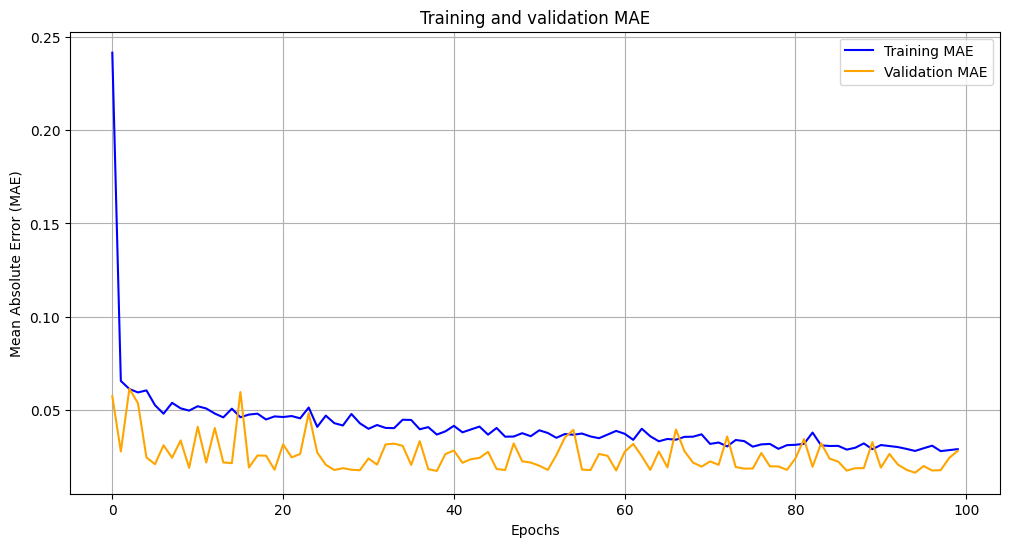

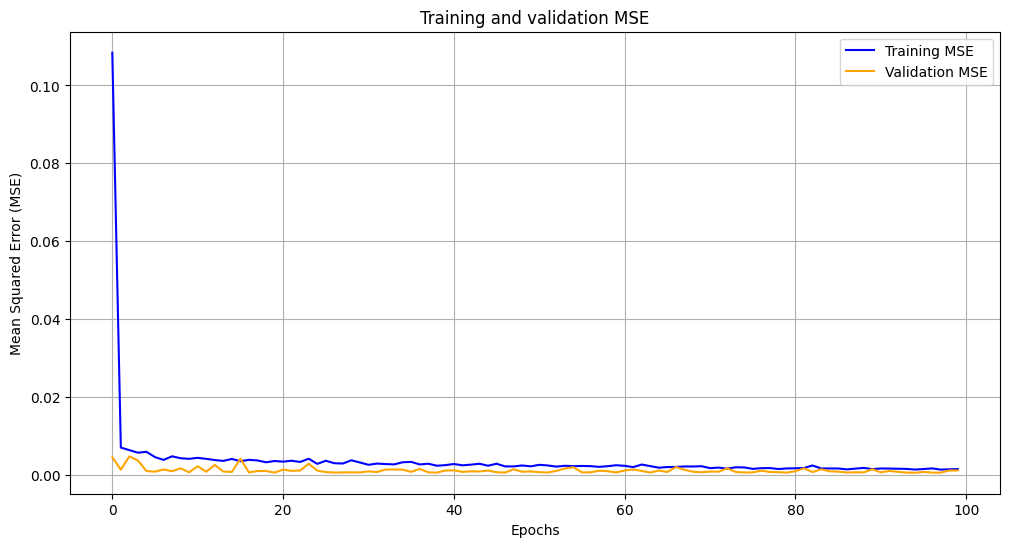

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Mean Absolute Error (MAE): 0.030
Mean Squared Error (MSE): 0.001
R^2 Score: 0.723
Mean Absolute Percentage Error (MAPE): 13.587%


In [286]:
history = lstm_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = lstm_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)


# Print Evaluation Metrics
lstm_metric =  print_evaluation_metrics(y_true, y_pred)


lstm_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

# 5. Recurrent Model

### 5.1 Build base model

In [287]:
rnn_base_model = Sequential()
rnn_base_model.add(layers.SimpleRNN(units=64, activation='relu', input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])))
rnn_base_model.add(layers.Dense(1))
    
rnn_base_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

rnn_base_history = rnn_base_model.fit(train_feature_seq, train_target_seq, epochs=50, batch_size=32, validation_data=(validation_feature_seq, validation_target_seq))

Epoch 1/50


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0144 - mae: 0.0944 - mse: 0.0144 - val_loss: 0.0019 - val_mae: 0.0364 - val_mse: 0.0019
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - mae: 0.0397 - mse: 0.0027 - val_loss: 0.0011 - val_mae: 0.0265 - val_mse: 0.0011
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - mae: 0.0274 - mse: 0.0012 - val_loss: 0.0014 - val_mae: 0.0306 - val_mse: 0.0014
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - mae: 0.0303 - mse: 0.0015 - val_loss: 9.6233e-04 - val_mae: 0.0240 - val_mse: 9.6233e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - mae: 0.0294 - mse: 0.0013 - val_loss: 9.5949e-04 - val_mae: 0.0238 - val_mse: 9.5949e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - mae: 0.0278 - mse: 0.0012 - val_loss: 6.7750e-04 - val_mae: 0.0195 - val_mse: 6.7750e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7477e-04 - mae: 0.0206 - mse: 6.7477e-0

### 5.2 Evaluate base model 

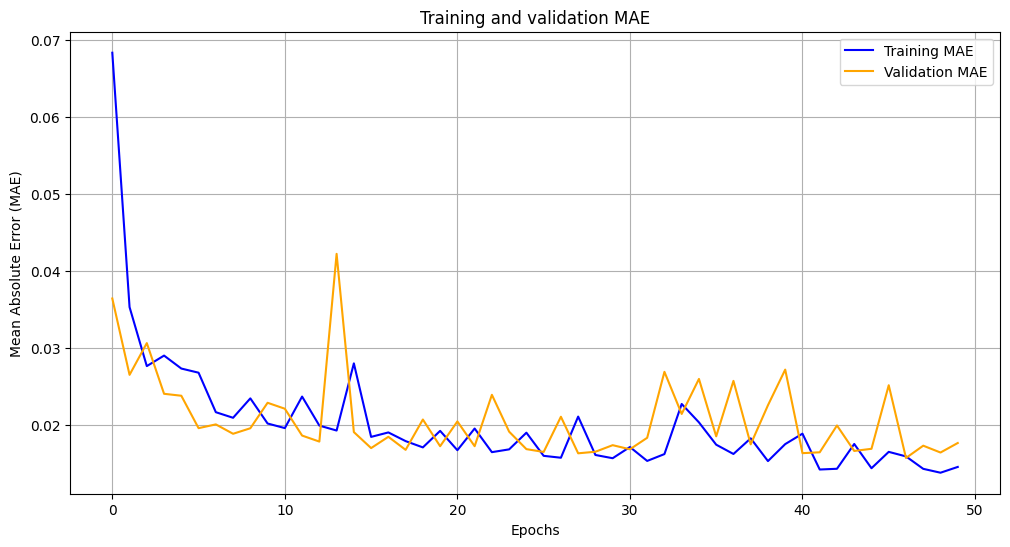

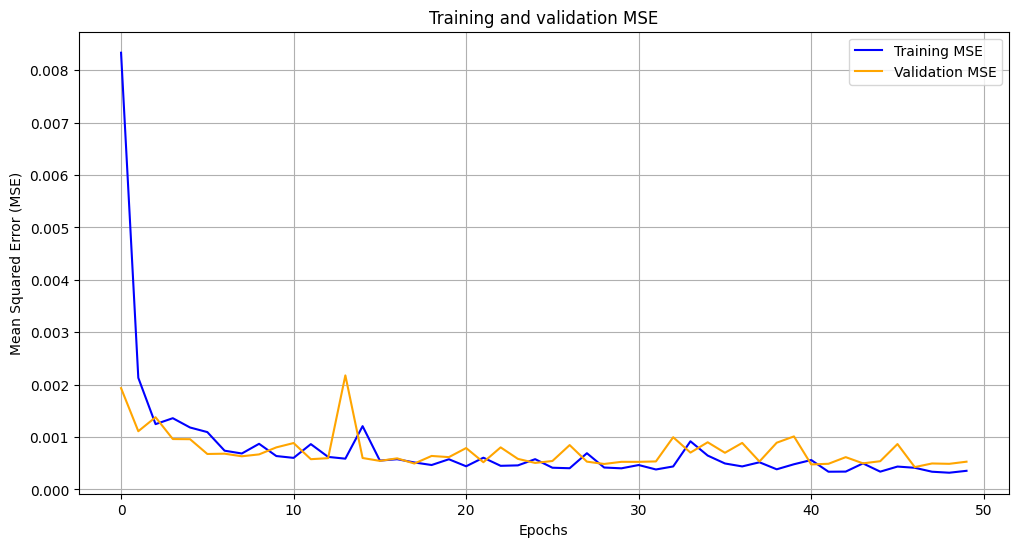

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Mean Absolute Error (MAE): 0.019
Mean Squared Error (MSE): 0.001
R^2 Score: 0.826
Mean Absolute Percentage Error (MAPE): 12.611%


In [288]:
history = rnn_base_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = rnn_base_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
rnn_base_metric = print_evaluation_metrics(y_true, y_pred)

### 5.3 Hyper-tune RNN model

In [289]:
# Build RNN model
def build_model(hp):
	model = Sequential()
	num_layers = hp.Int('num_layers', min_value=1, max_value=4)
	for i in range(num_layers):
		model.add(layers.SimpleRNN(
			units=hp.Int(f'units_{i}', min_value=16, max_value=62, step=16),
			activation='relu',
			return_sequences=(i != num_layers - 1),
			input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2]) if i == 0 else None
		))
		model.add(layers.Dropout(0.1))
	
	model.add(layers.Dense(units=1))  # Output layer

	model.compile(
		optimizer=tf.keras.optimizers.Adam(
			learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
		),
		loss='mean_squared_error',
		metrics=['mae', 'mse']
	)
	return model

# Hyperband tuner
tuner = kt.Hyperband(
	build_model,
	objective='val_loss',
	max_epochs=25,
	factor=3,
	directory='nn_cache',
	project_name='RNN'
)

# Search for the best hyperparameters
tuner.search(train_feature_seq, train_target_seq, epochs=50, validation_data=(validation_feature_seq, validation_target_seq), batch_size=32)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

Reloading Tuner from nn_cache/RNN/tuner0.json


{'num_layers': 1,
 'units_0': 32,
 'learning_rate': 0.00104935888624918,
 'units_1': 16,
 'units_2': 48,
 'units_3': 48,
 'tuner/epochs': 25,
 'tuner/initial_epoch': 9,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0021'}

### 5.4 Build Hyper-tune model 

In [290]:
rnn_model = tuner.hypermodel.build(best_hps)
rnn_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
# Train final model
rnn_history = rnn_model.fit(
    train_feature_seq, train_target_seq,
    epochs=100,
    batch_size=50,
    validation_data=(validation_feature_seq, validation_target_seq),
)

Epoch 1/100


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2219 - mae: 1.2219 - mse: 1.6761 - val_loss: 0.2951 - val_mae: 0.2951 - val_mse: 0.0995
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2298 - mae: 0.2298 - mse: 0.0802 - val_loss: 0.0803 - val_mae: 0.0803 - val_mse: 0.0101
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1498 - mae: 0.1498 - mse: 0.0380 - val_loss: 0.0634 - val_mae: 0.0634 - val_mse: 0.0066
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1149 - mae: 0.1149 - mse: 0.0232 - val_loss: 0.0411 - val_mae: 0.0411 - val_mse: 0.0029
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1133 - mae: 0.1133 - mse: 0.0232 - val_loss: 0.0339 - val_mae: 0.0339 - val_mse: 0.0020
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0997 - mae: 0.0997 - mse: 0.0183 - val_loss: 0.0329 - val_mae: 0.0329 - val_mse: 0.0018
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1029 - mae: 0.1029 - mse: 0.0192 - val_loss: 0.0305 - va

### 5.4 Evaluate Hyper-tuned model

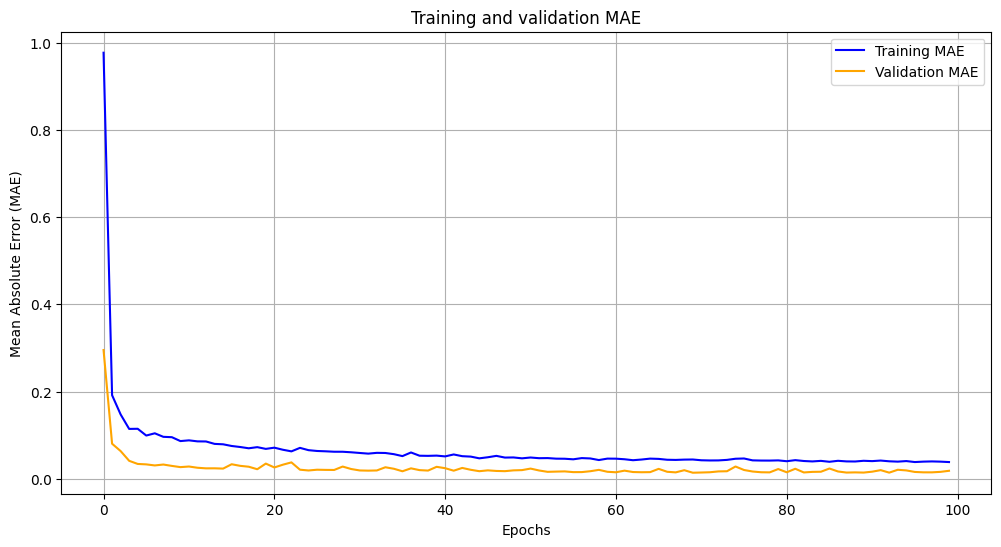

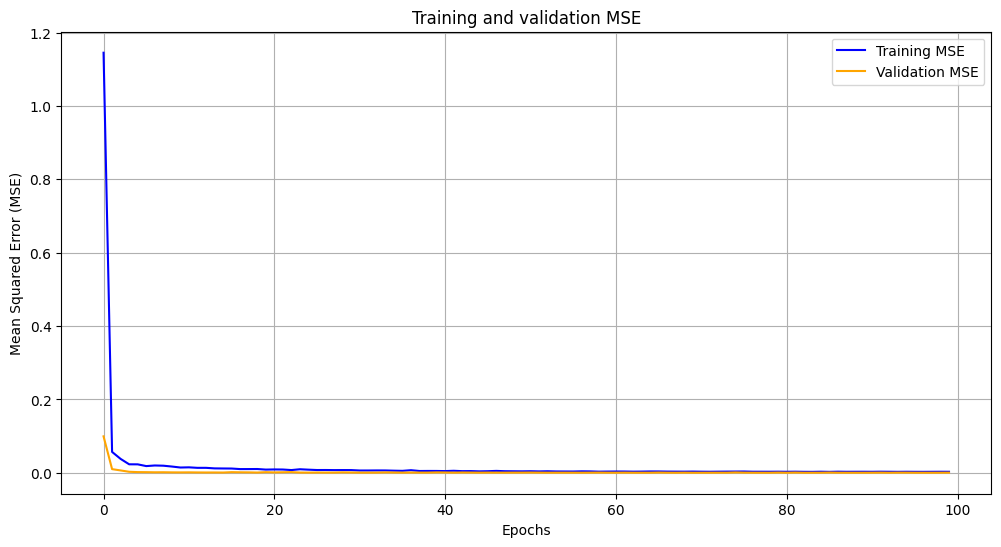

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Mean Absolute Error (MAE): 0.026
Mean Squared Error (MSE): 0.001
R^2 Score: 0.797
Mean Absolute Percentage Error (MAPE): 12.317%


In [291]:
history = rnn_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = rnn_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
rnn_metric =  print_evaluation_metrics(y_true, y_pred)


rnn_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

# 6. CNN_LSTM Model

### 6.1 Develop Base Model

In [292]:
cl_base_model = keras.Sequential()

cl_base_model.add(layers.Input(shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])))
cl_base_model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
cl_base_model.add(layers.LSTM(units=64, return_sequences=False))
cl_base_model.add(layers.Dense(units=1, activation='linear'))
cl_base_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

cl_base_history = cl_base_model.fit(train_feature_seq, train_target_seq, epochs=50, batch_size=32, validation_data=(validation_feature_seq, validation_target_seq))


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1728 - mae: 0.3319 - mse: 0.1728 - val_loss: 0.0035 - val_mae: 0.0472 - val_mse: 0.0035
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142 - mae: 0.0952 - mse: 0.0142 - val_loss: 0.0060 - val_mae: 0.0663 - val_mse: 0.0060
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - mae: 0.0496 - mse: 0.0038 - val_loss: 0.0018 - val_mae: 0.0332 - val_mse: 0.0018
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - mae: 0.0349 - mse: 0.0022 - val_loss: 0.0013 - val_mae: 0.0277 - val_mse: 0.0013
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - mae: 0.0324 - mse: 0.0018 - val_loss: 0.0015 - val_mae: 0.0282 - val_mse: 0.0015
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - mae: 0.0310 - mse: 0.0016 - val_loss: 9.7204e-04 - val_mae: 0.0251 - val_mse: 9.7204e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - mae: 0.0296 - mse: 0.0015 - val_loss:

### 6.2 Evaluate Base Model

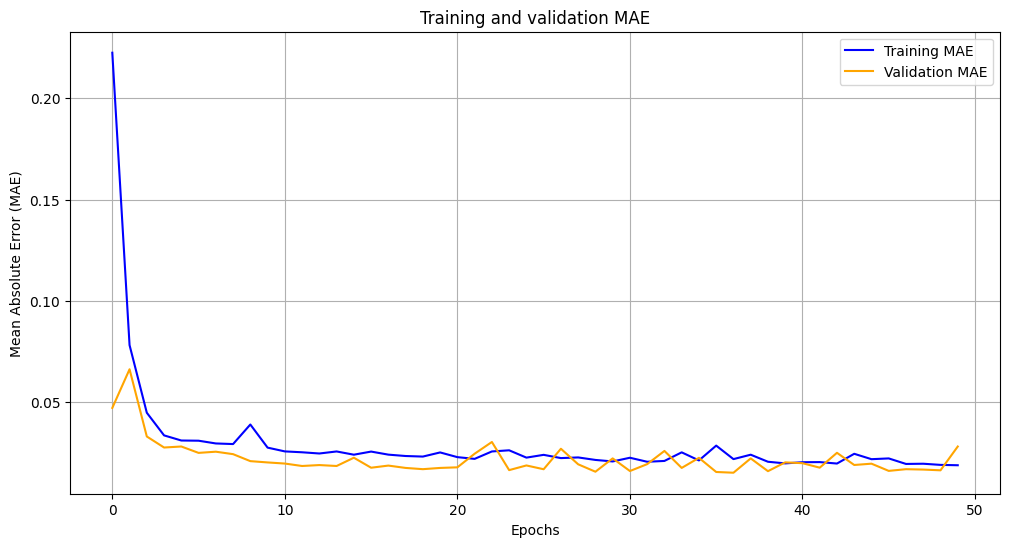

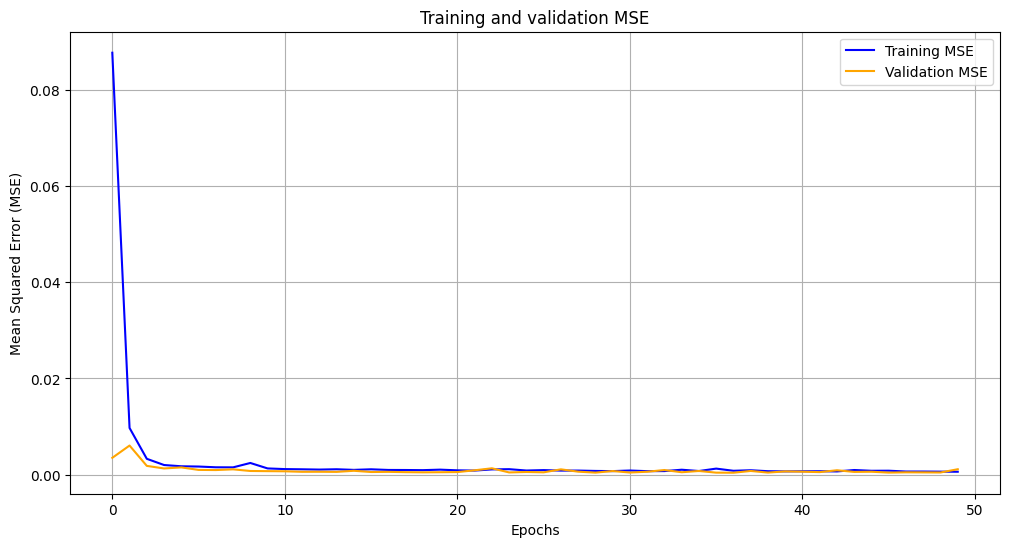

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Absolute Error (MAE): 0.019
Mean Squared Error (MSE): 0.001
R^2 Score: 0.826
Mean Absolute Percentage Error (MAPE): 12.611%


In [293]:
history = cl_base_history.history
train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = rnn_base_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
cl_base_metric =  print_evaluation_metrics(y_true, y_pred)

### 6.3 Hyper-tune model

In [294]:
# Define LSTM-CNN Model with hyper-tuning for the number of layers
def build_lstm_cnn_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])))
    
    for i in range(hp.Int('num_cnn_layers', 1, 2)):
        model.add(layers.Conv1D(
            filters=hp.Int(f'cnn_filters_{i}', min_value=50, max_value=100, step=25),
            kernel_size=hp.Choice(f'cnn_kernel_size_{i}', values=[1, 2]),
            activation='relu'
        ))
    
    # Hyper-tuning number of LSTM layers
    for i in range(hp.Int('num_lstm_layers', 1, 2)):
        model.add(layers.LSTM(
            units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=64, step=8),
            return_sequences=True if i < hp.get('num_lstm_layers') - 1 else False
        ))
        model.add(layers.Dropout(hp.Float('dropout_rate', 0.1, 0.2, step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae', 'mse']
    )
    return model

print(train_target_seq)
# Hyperband tuner
tuner = kt.Hyperband(
    build_lstm_cnn_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='nn_cache',
    project_name='lstm_cnn'
)

# Run Hyperband tuning
tuner.search(train_feature_seq, train_target_seq, validation_data=(validation_feature_seq, validation_target_seq), epochs=50, batch_size=32)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

[0.45701096 0.47345643 0.45960762 0.48009233 0.48788229 0.48788229
 0.5389498  0.51990767 0.48355453 0.49307559 0.46653203 0.44489325
 0.46537796 0.45729948 0.42729371 0.41950375 0.39844201 0.41748413
 0.43450664 0.43998846 0.42325447 0.4169071  0.46682054 0.42469706
 0.45527986 0.46826313 0.50086555 0.52279284 0.53433353 0.5372187
 0.5712637  0.56347374 0.57039815 0.57991922 0.54818234 0.51759954
 0.52336988 0.53029429 0.51933064 0.48326601 0.46624351 0.49134449
 0.51211771 0.49192152 0.47922677 0.45441431 0.43941143 0.46566647
 0.49422966 0.4965378  0.49711483 0.50894403 0.52798615 0.53404501
 0.53952683 0.55308713 0.5406809  0.51500289 0.54183497 0.53433353
 0.51673399 0.54875938 0.57818811 0.57328332 0.57732256 0.58972879
 0.6203116  0.63531448 0.64079631 0.66387767 0.68695903 0.65983843
 0.67339873 0.69186382 0.69186382 0.66532025 0.6762839  0.67570687
 0.66733987 0.67830352 0.68234276 0.67916907 0.71494518 0.70311598
 0.69215234 0.67166763 0.67109059 0.68465089 0.70628967 0.70513

In [295]:
lc_model = tuner.hypermodel.build(best_hps)
lc_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
# Train final model
lc_history = lc_model.fit(
    train_feature_seq, train_target_seq,
    epochs=200,
    batch_size=16,
    validation_data=(validation_feature_seq, validation_target_seq),
)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2324 - mae: 0.2324 - mse: 0.1041 - val_loss: 0.0259 - val_mae: 0.0259 - val_mse: 0.0010
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0602 - mae: 0.0602 - mse: 0.0061 - val_loss: 0.0505 - val_mae: 0.0505 - val_mse: 0.0031
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0669 - mae: 0.0669 - mse: 0.0078 - val_loss: 0.0233 - val_mae: 0.0233 - val_mse: 8.0775e-04
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0514 - mae: 0.0514 - mse: 0.0044 - val_loss: 0.0535 - val_mae: 0.0535 - val_mse: 0.0033
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0588 - mae: 0.0588 - mse: 0.0053 - val_loss: 0.0219 - val_mae: 0.0219 - val_mse: 8.2749e-04
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0503 - mae: 0.0503 - mse: 0.0041 - val_loss: 0.0409 - val_mae: 0.0409 - val_mse: 0.0021
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0577 - mae: 0.0577 - mse: 0.0055 - va

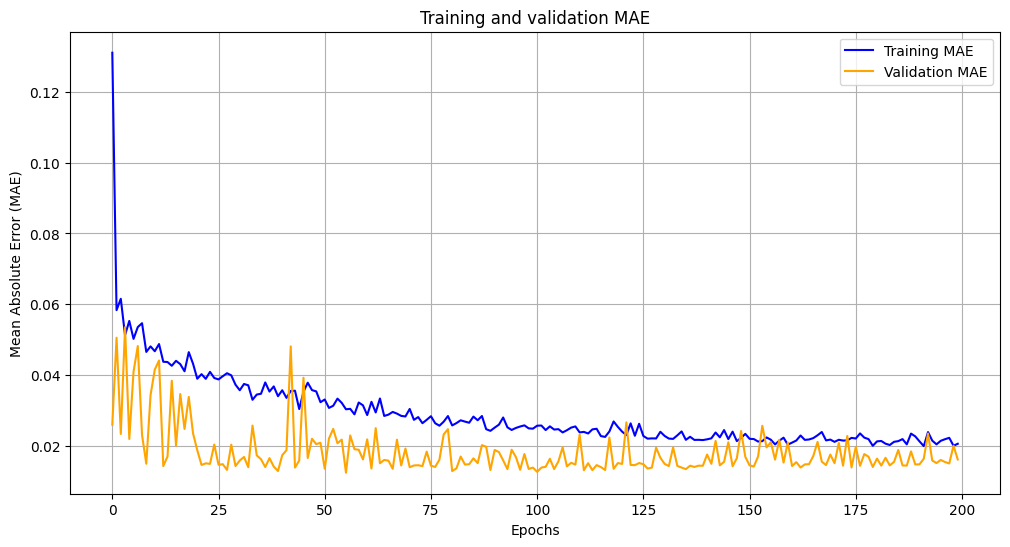

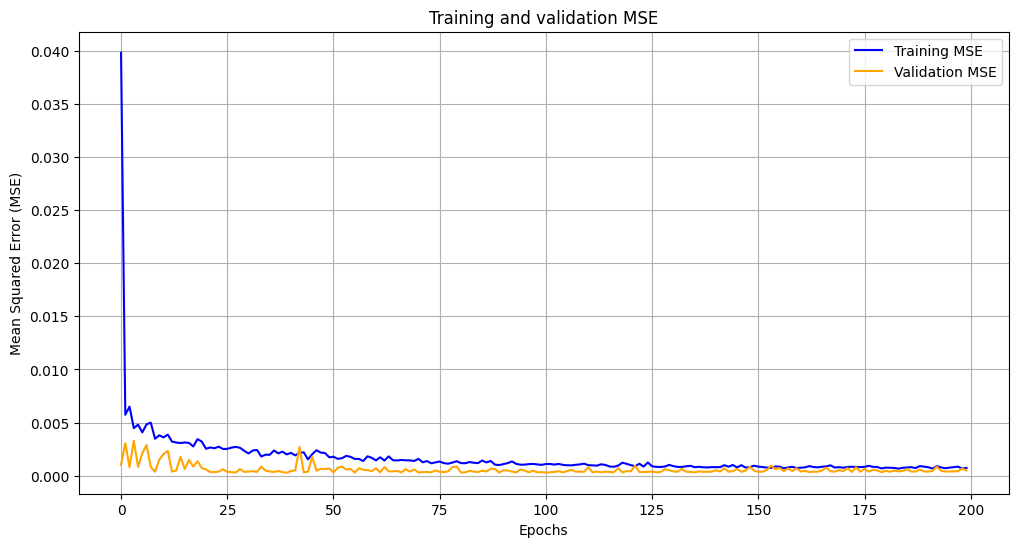

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Mean Absolute Error (MAE): 0.016
Mean Squared Error (MSE): 0.000
R^2 Score: 0.909
Mean Absolute Percentage Error (MAPE): 12.597%


In [296]:
def evaluate_model(history, model, test_features, test_target):
	# Extract training and validation metrics
	train_mae, train_mse = history['mae'], history['mse']
	validate_mae, validate_mse = history['val_mae'], history['val_mse']

	# Plot the training and validation MAE and MSE
	plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
	plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

	# Get model predictions on Test Data
	y_pred = model.predict(test_features)
	y_true = pd.DataFrame(test_target)

	# Print Evaluation Metrics
	metric  = print_evaluation_metrics(y_true, y_pred)

	return metric, y_pred

lc_metric, y_pred =  evaluate_model(lc_history.history, lc_model, test_feature_seq, test_target_seq)
lc_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))


# Plot all metrics in a single table

In [297]:
metrics = [dnn_metric, lstm_metric, rnn_metric, lc_metric]  

df = pd.DataFrame()
# Initialize the DataFrame with appropriate columns
df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'R Square', 'MAPE'])

# Populate the DataFrame with metrics
for i, m in enumerate(metrics):
	df = pd.concat([df, pd.DataFrame([{
		'Model': f'Model {i + 1}',
		'MAE': m['MAE'],
		'MSE': m['MSE'],
		'R Square': m['R Square'],
		'MAPE': m['MAPE']
	}])], ignore_index=True)

df
        

/var/folders/xz/1gn0m18n5k1bjmbt205k50cm0000gn/T/ipykernel_35578/999570319.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{


,Model,MAE,MSE,R Square,MAPE
0,Model 1,0.008929,0.000571,0.885641,1.773947
1,Model 2,0.030186,0.001348,0.722595,13.587184
2,Model 3,0.026320,0.000985,0.797171,12.316785
3,Model 4,0.016209,0.000441,0.909308,12.596729


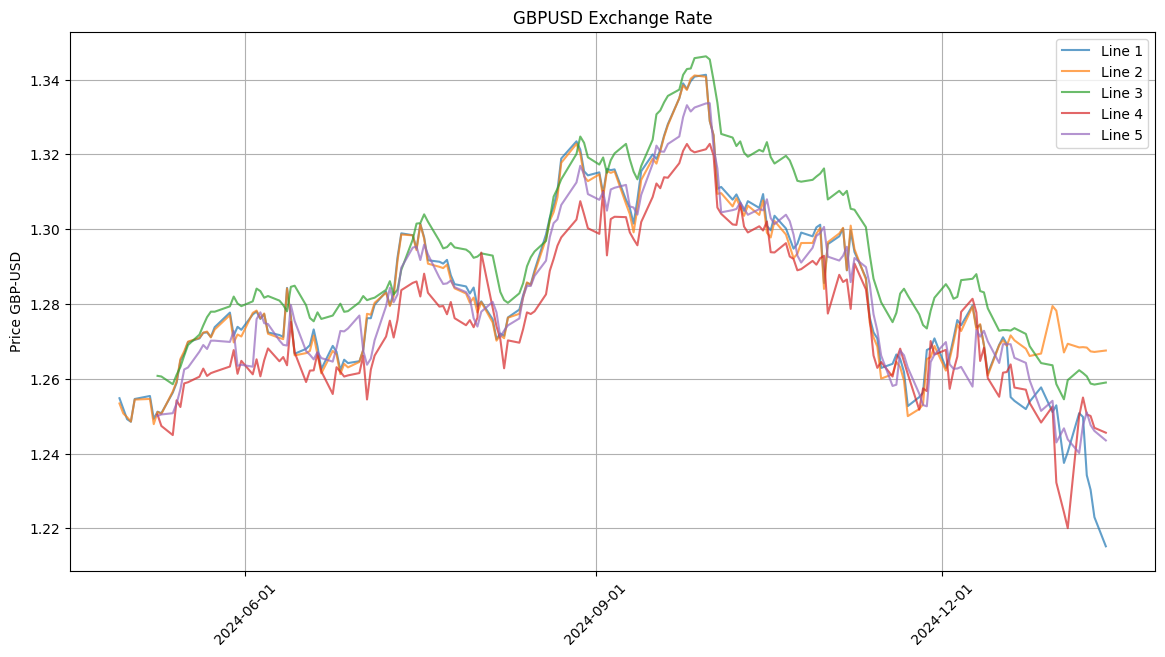

In [ ]:
dnn_features = ['Trend', 'Seasonality', 'Noise', 'Week', 'Month', 'Day', 'Open']

plot_gbp_usd([
	[test['Date'], u_test['Open']],
	[test['Date'], dnn_predicted],
	[test['Date'][7:], lstm_pred.flatten()],
	[test['Date'][7:], rnn_pred.flatten()],
	[test['Date'][7:], lc_pred.flatten()],
])